# Predição do Estado de uma Smart Grid

## Bibliotecas

In [1]:
# Biblioteca para coletar os dados da rede simulada
from ucimlrepo import fetch_ucirepo 

# Bibliotecas para análise e manipulação dos dados
import numpy as np
import pandas as pd

# Charts and Visualization
from matplotlib import pyplot as plt

# Machine Learning Libraries
import xgboost
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor


# Domínio da Aplicação

## Exploração da Base de Dados

### Coletando os [dados simulados de estabilidade de uma rede elétrica](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)

In [2]:
electrical_grid_stability_simulated_data = fetch_ucirepo(id=471).data

features = electrical_grid_stability_simulated_data.features 
targets = electrical_grid_stability_simulated_data.targets

data = pd.merge(features, targets, left_index=True, right_index=True, how='outer')

### Explicando os Atributos

- tau[x]: Tempo de reação do participante (valor real no intervalo [0.5, 10] segundos). 
    - tau1 - o valor para o produtor de eletricidade;
- p[x]: Potência nominal consumida (negativa) ou produzida (positiva) (valor real). 
    - Para consumidores, no intervalo [-0.5, -2] segundos^-2;
    - p1 = abs(p2 + p3 + p4);
- g[x]: Coeficiente (gamma) proporcional à elasticidade de preço (valor real no intervalo [0.05, 1] segundos^-1). 
    - g1 - o valor para o produtor de eletricidade;
- stab: A parte real máxima da raiz da equação característica (se positiva - o sistema é linearmente instável) (valor real).
- stabf: A classificação de estabilidade do sistema (categórica: estável/instável).


### Visualização os Dados

In [3]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


# Pré-Processamento dos Dados

### Eliminação do dado discreto, `stabf`

Com o objetivo de prever o próximo estado da rede, a partir do valor contínuo `stab`, temos que eliminar o valor `stabf` já que depende de `stab`.

In [4]:
data.drop(columns=['stabf'], inplace=True)

### Criação de Dados

Criar mais dados a partir das médias, para verificar novas correlações

In [5]:
# data['p_std'] = (data['p1'] + data['p2'] + data['p3'] + data['p4']) / 4
# data['g_std'] = (data['g1'] + data['g2'] + data['g3'] + data['g4']) / 4

### Análise das Correlações

In [6]:
correlation_matrix = data.corr()

correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['first_column', 'second_column', 'correlation']

# Remover duplicatas e auto-correlacoes
correlation_pairs = correlation_pairs[correlation_pairs['first_column'] != correlation_pairs['second_column']]
correlation_pairs = correlation_pairs.drop_duplicates(subset=['correlation'])

# Ordenar pelo valor absoluto da correlação
corr_max = correlation_pairs.sort_values(by='correlation', ascending=False)
corr_min = correlation_pairs.sort_values(by='correlation')

# Selecionar os maiores valores de correlação
print("Maiores Correlações")
print(corr_max.head(10))
print('\n')
print("Menores Correlações")
print(corr_min.head(10))

Maiores Correlações
    first_column second_column  correlation
142           g3          stab     0.308235
129           g2          stab     0.293601
25          tau2          stab     0.290975
116           g1          stab     0.282774
38          tau3          stab     0.280700
155           g4          stab     0.279214
51          tau4          stab     0.278576
12          tau1          stab     0.275761
4           tau1            p1     0.027183
76            p2            g4     0.019817


Menores Correlações
    first_column second_column  correlation
58            p1            p3    -0.584554
59            p1            p4    -0.579239
57            p1            p2    -0.573157
103           p4          stab    -0.020786
74            p2            g2    -0.018032
33          tau3            p4    -0.017531
3           tau1          tau4    -0.017265
6           tau1            p3    -0.015924
7           tau1            p4    -0.015807
5           tau1            p2    

## Limpeza os dados

Temos algumas providencias a serem tomadas antes de excluir ou tomar qualquer outra atitude para correlações baixas

Com os dados acima temos que os g tem grande impacto no stab e o stab tem muito impacto no stabf que é o objetivo final
Portanto o mais importante agora é ver o que fazer com os p

In [7]:
data.drop(columns=['p1', 'p2', 'p3', 'p4'], inplace=True)

# Reconhecimento de Padrões e Aprendizados

## Definição de Métodos e Classes de Apoio

In [8]:
def create_error_structure():
    return {
        "mse": [],
        "mae": [],
        "mape": [],
        "r2": []
    }

class Fitter:
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.__x_train = x_train
        self.__y_train = y_train
        self.__x_test = x_test
        self.__y_test = y_test

    def fit_model_and_measure(self, model, data):
        model.fit(self.__x_train, self.__y_train)
        
        pred = model.predict(self.__x_test)

        data['mse'].append(mean_squared_error(self.__y_test, pred))
        data['mape'].append(np.mean(np.abs((self.__y_test - pred) / self.__y_test)) * 100)
        data['mae'].append(mean_absolute_error(self.__y_test, pred))
        data['r2'].append(r2_score(self.__y_test, pred))  # Adicionando a métrica r2


## Treinamento e Validação dos Modelos

In [22]:
# Estruturas de erros para cada modelo
liner_regressor_data = create_error_structure()
tree_regressor_data = create_error_structure()
xgboost_regressor_data = create_error_structure()
svr_data = create_error_structure()
random_forest_data = create_error_structure()
lightgbm_regressor_data = create_error_structure()
knn_regressor_data = create_error_structure()

# K-Fold para divisão dos dados
five_folds = KFold(n_splits=5, random_state=0, shuffle=True)

# Índice da coluna de 'stab'
STAB_COLUMN_INDEX = list(data.columns).index('stab')

# Loop sobre os folds
for index, (train_index, test_index) in enumerate(five_folds.split(data)):
    y_train = data.values[train_index][:, STAB_COLUMN_INDEX]
    x_train = data.values[train_index]
    x_train = np.delete(x_train, STAB_COLUMN_INDEX, 1)

    y_test = data.values[test_index][:, STAB_COLUMN_INDEX]
    x_test = data.values[test_index]
    x_test = np.delete(x_test, STAB_COLUMN_INDEX, 1)

    fitter = Fitter(
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
    )

    # Modelo LightGBM
    lgbm_regressor = LGBMRegressor(max_depth=10)
    fitter.fit_model_and_measure(lgbm_regressor, data=lightgbm_regressor_data)

    # Modelo KNN Regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=5)  # n_neighbors pode ser ajustado
    fitter.fit_model_and_measure(knn_regressor, data=knn_regressor_data)
    
    lasso = linear_model.Lasso(alpha=0.1)
    fitter.fit_model_and_measure(lasso, liner_regressor_data)

    tree = DecisionTreeRegressor(max_depth=5, splitter='random', min_samples_leaf=5)
    fitter.fit_model_and_measure(tree, tree_regressor_data)

    xgb_regressor = xgboost.sklearn.XGBRegressor()
    fitter.fit_model_and_measure(xgb_regressor, xgboost_regressor_data)

    svr = SVR()
    fitter.fit_model_and_measure(svr, svr_data)

    random_forest = RandomForestRegressor(n_estimators=100, random_state=0)
    fitter.fit_model_and_measure(random_forest, random_forest_data)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 0.015635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 0.015466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 80

# Pós-Processamento e Conclusão

## Definindo funções de apoio

In [23]:
def create_metrics(error_structure):
    metrics = {
        'MSE': error_structure['mse'], 
        'MAE': error_structure['mae'], 
        'MAPE': error_structure['mape'],
        'R2': error_structure['r2']  # Adicionando a métrica r2
    }

    print(metrics)

    mean_std = {metric: (np.mean(scores), np.std(scores)) for metric, scores in metrics.items()}

    return mean_std

{'MSE': [np.float64(0.001376129491866354), np.float64(0.0014067259016848075), np.float64(0.0013803387067353183), np.float64(0.0012851124010548512), np.float64(0.0013674506030640176)], 'MAE': [np.float64(0.0314525400415256), np.float64(0.03198506877534543), np.float64(0.03132942398311239), np.float64(0.030269516710787623), np.float64(0.03136529555890624)], 'MAPE': [np.float64(3266.1563113743773), np.float64(182.71237185576038), np.float64(240.14662651547698), np.float64(202.51763363497966), np.float64(766.0148305113072)], 'R2': [-0.0001677711687968486, -0.0012456711912938179, -0.0006960918543277295, -6.639318007373163e-06, -0.0006137898482021509]}
{'MSE': [np.float64(0.0007755580354173497), np.float64(0.0007441090725585776), np.float64(0.0007503344696811037), np.float64(0.0007240992066125903), np.float64(0.000720679081006176)], 'MAE': [np.float64(0.02243378725158754), np.float64(0.021942450434849818), np.float64(0.02220324202227109), np.float64(0.021704406995836464), np.float64(0.022019

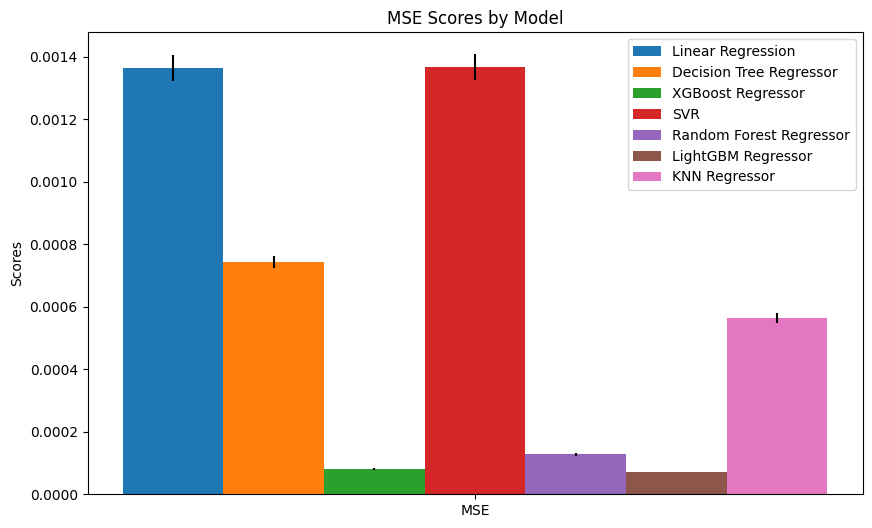

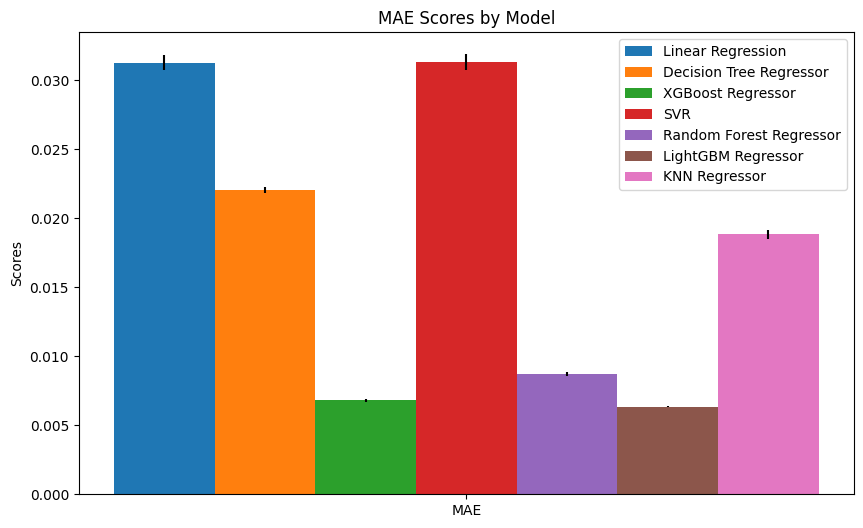

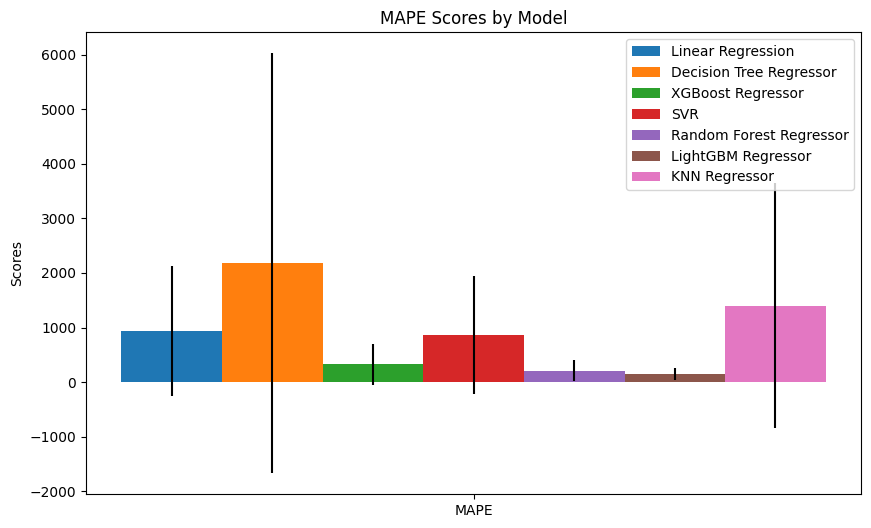

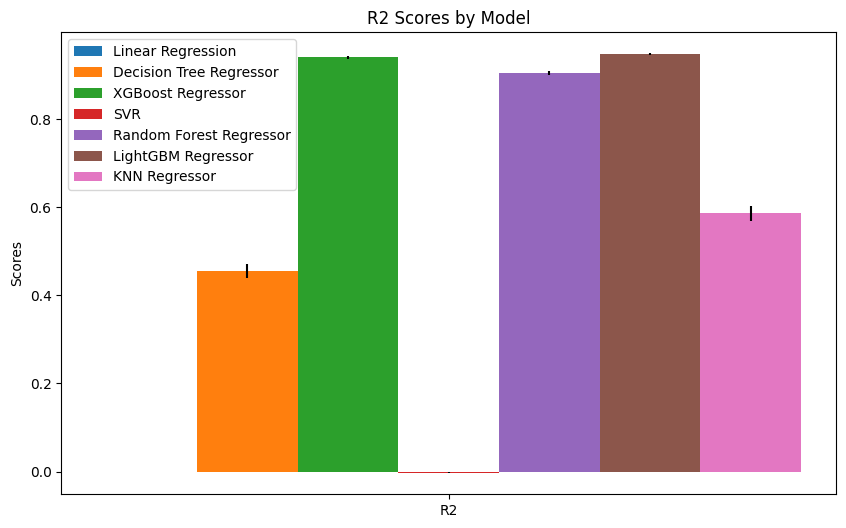


Linear Regression Metrics:
Mean MSE: 0.0014
Mean MAE: 0.0313
Mean MAPE: 931.5096
Mean R2: -0.0005

Decision Tree Regressor Metrics:
Mean MSE: 0.0007
Mean MAE: 0.0221
Mean MAPE: 2176.8147
Mean R2: 0.4544

XGBoost Regressor Metrics:
Mean MSE: 0.0001
Mean MAE: 0.0068
Mean MAPE: 326.8172
Mean R2: 0.9402

SVR Metrics:
Mean MSE: 0.0014
Mean MAE: 0.0313
Mean MAPE: 861.2108
Mean R2: -0.0026

Random Forest Regressor Metrics:
Mean MSE: 0.0001
Mean MAE: 0.0087
Mean MAPE: 207.2096
Mean R2: 0.9056

LightGBM Regressor Metrics:
Mean MSE: 0.0001
Mean MAE: 0.0064
Mean MAPE: 154.6250
Mean R2: 0.9477

KNN Regressor Metrics:
Mean MSE: 0.0006
Mean MAE: 0.0189
Mean MAPE: 1403.2612
Mean R2: 0.5859


In [24]:
# Regressão Linear

linear_mean_std = create_metrics(liner_regressor_data)
tree_mean_std = create_metrics(tree_regressor_data)
xgboost_mean_std = create_metrics(xgboost_regressor_data)
svr_mean_std = create_metrics(svr_data)
random_forest_mean_std = create_metrics(random_forest_data)
lightgbm_mean_std = create_metrics(lightgbm_regressor_data)
knn_mean_std = create_metrics(knn_regressor_data)

# Função para plotar gráficos de métricas
def plot_metrics(metric_name, model_metrics, labels):
    width = 0.2
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (model_name, metric_values) in enumerate(model_metrics.items()):
        rects = ax.bar(x + i * width, [metric_values[metric_name][0] for metric_name in labels], width, label=model_name, yerr=[metric_values[metric_name][1] for metric_name in labels])

    ax.set_ylabel('Scores')
    ax.set_title(f'{metric_name} Scores by Model')
    ax.set_xticks(x + width * (len(model_metrics) - 1) / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Dicionário para armazenar os dados de cada modelo
model_metrics = {
    "Linear Regression": linear_mean_std,
    "Decision Tree Regressor": tree_mean_std,
    "XGBoost Regressor": xgboost_mean_std,
    "SVR": svr_mean_std,
    "Random Forest Regressor": random_forest_mean_std,
    "LightGBM Regressor": lightgbm_mean_std,
    "KNN Regressor": knn_mean_std
}

# Labels de métricas
metrics_to_plot = ['MSE', 'MAE', 'MAPE', 'R2']

# Plotar gráficos para cada métrica
for metric in metrics_to_plot:
    plot_metrics(metric, model_metrics, [metric])

# Exibindo as médias de cada modelo
for model_name, model_mean_std in model_metrics.items():
    print(f"\n{model_name} Metrics:")
    for metric in metrics_to_plot:
        print(f"Mean {metric}: {model_mean_std[metric][0]:.4f}")

# Conclusão

Responder à pergunta: "Você acredita que será possível entregar tudo que prometeu no documento da Proposta?"


Sim, por mais que esteja apenas no começo do projeto, já é possivel fazer algumas análises utilizando regressão linear e arvore de regressão como visto em aula, com o que já temos fica facil crial pipelines para os ajustes nos dados e também abre a possibilidade para random forests. Com o objetivo final de evitar overfitting e garantir também que seja possivel obter respostas e tomadas de decisões razoáveis em relação aos dados estabelecidos.